# Using the Abacus

The purpose of the abacus is to access quickly existing, previously computed RTBP orbit solutions, and keep track of the orbit solution produced.

## Configuration

In [1]:
import r3bpy
from r3bpy.orbits import abaq

In [2]:
abacus = abaq.Abaq(directory='./', file='r3bp_abaq.hdf5')

To check the source, use

In [3]:
abacus.get_source()

'.//r3bp_abaq.hdf5'

## Abacus structure

The abacus is inherited from HDF5 file structure. It is thus organized by 'folder', where each folder level correspond to a feature of the orbit.

The structure is then: Primary Name / Secondary Name / ...

In [4]:
abacus.list("Earth")

['Moon']

In [5]:
abacus.list("Earth/Moon")

['Butterfly', 'DRO', 'Halo', 'NRHO']

Using list on the primary/secondary, we get the list of orbit type

In [6]:
abacus.list("Earth/Moon/NRHO")

['L1', 'L2']

And likewise, with  Primary Name / Secondary Name / Orbit Type /  we get the list of center point of the orbit.

Center point can be any of {P1, P2} for the primaries, and {L1, L2, L3, L4, L5} for the Lagrange points.

In [7]:
print(abacus)

Abaq=
Earth
  Moon
    Butterfly: ['L2']
    DRO: ['P1', 'P2']
    Halo: ['L1', 'L2']
    NRHO: ['L1', 'L2']



## Reading from the Abacus

Finally then, to extract a NRHO in the Earth-Moon restricted tree bory system, around L1, we use:

In [8]:
mu_ratio, init_point, period, trajectory, description = abacus.get_data("Earth", "Moon", "NRHO", "L1")
print(description)
print(period)

b'NRHO, Southern, L1'
[2.3742516]


This return some parameters of the orbit. We can for instance propagate the orbit from the initial point. We all goes well we should be able to plot an orbit!

In [9]:
from r3bpy.main import Propagator
from r3bpy.main import Problem
problem = Problem(float(mu_ratio))
propagator = Propagator(float(mu_ratio))

In [12]:
t_nrho, xyz_nrho = propagator.propagate(list(init_point), [0, float(period)])

and now we can plot the current solution and the RTBP configuration

<Axes3DSubplot:xlabel='x (DU)', ylabel='y (DU)'>

<Figure size 720x720 with 0 Axes>

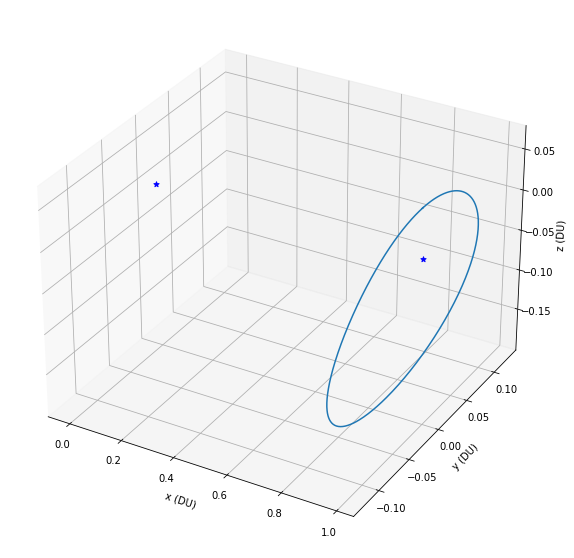

In [13]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]
from r3bpy.visu import plot_system, plot_trajectory

fig = plt.figure()
ax = plot_system(problem, is2d=False, withPrimaries=True, withTriangularPoints=False, withCollinearPoints=False)
plot_trajectory(xyz_nrho, ax=ax)

## Writing to the Abacus

Writing to the abacus is as easy as reading from it. We need however to prepare a set of information of our orbit, the same we extract when reading an orbit from the abacus.


We will construct a DRO and put it in the database.

In [14]:
from r3bpy.orbits import DistantRetrogradeOrbit
import r3bpy.core as constants
from r3bpy.main import Problem, PrimaryPointId

m1 = constants.MU_EARTH
r12 = constants.DISTANCE_EARTH_MOON
m2 = constants.MU_MOON
x_init = 1.1

problem = Problem(m1, m2, r12)

dro = DistantRetrogradeOrbit(problem.get_mu_ratio(), PrimaryPointId.P2)

In [15]:
dro_orbit = dro.find_orbit(x_init)

to check, just plot it

<Axes3DSubplot:xlabel='x (DU)', ylabel='y (DU)'>

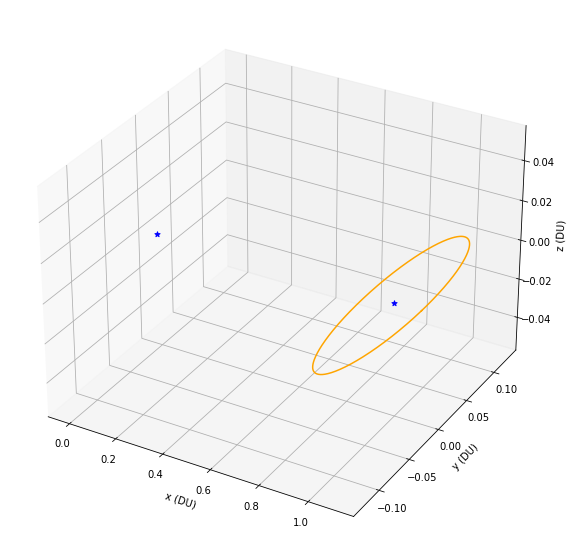

In [16]:
from r3bpy.visu import plot_system, plot_trajectory

ax = plot_system(problem, is2d=False, withPrimaries=True, withTriangularPoints=False, withCollinearPoints=False)
orbit_period = dro_orbit.period
_, xyz = dro_orbit.propagate([0, dro_orbit.period])
plot_trajectory(xyz, color='orange', ax=ax)

Since everything look good, let's save it to the database

In [17]:
abacus.add_to_abaq("Earth", "Moon", "DRO", "P2", mu_ratio, xyz[1][0:6], orbit_period, "orbit from tutorial")

Caution: No check are currently made when writing to the abacus. You should thus be very consistent in the information you put, and not mixing definitions.

In [18]:
print(abacus)

Abaq=
Earth
  Moon
    Butterfly: ['L2']
    DRO: ['P1', 'P2']
    Halo: ['L1', 'L2']
    NRHO: ['L1', 'L2']



## Removing items

It is possible to remove a set of data from the abacus. As a protection, all elements of the orbit family are required.

In [19]:
deleted_item = abacus.remove_from_abaq("Earth", "Moon", "DRO", "P2")

The delete function return an dictionnary containing the information of the deleted object

In [20]:
deleted_item

{'cb1': 'Earth',
 'cb2': 'Moon',
 'family': 'DRO',
 'point': 'P2',
 'description': b'orbit from tutorial',
 'init_point': array([ 1.1       ,  0.        ,  0.        ,  0.        , -0.46018718,
         0.        ]),
 'mu_ratio': array([0.01215058], dtype=float32),
 'period': array([1.7056807], dtype=float32),
 'trajectory': array([], dtype=float32)}

We can check now that Earth/Moon/DRO/P2 is now missing from the abacus

In [21]:
print(abacus)

Abaq=
Earth
  Moon
    Butterfly: ['L2']
    DRO: ['P1']
    Halo: ['L1', 'L2']
    NRHO: ['L1', 'L2']



We can also add back the deleted item

In [22]:
abacus.add_to_abaq(**deleted_item)

In [23]:
print(abacus)

Abaq=
Earth
  Moon
    Butterfly: ['L2']
    DRO: ['P1', 'P2']
    Halo: ['L1', 'L2']
    NRHO: ['L1', 'L2']



And we observe that the item is back in the abacus!